## 1. 필요 정보 임포트 및 시드 고정

In [4]:
!pip install pynvml

In [1]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 34058272768
free     : 34058207232
used     : 65536


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from efficientunet import *
from torch.optim import lr_scheduler, Adam

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

def seed_all(seed = 42):
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    #random.seed(seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
seed_all()

## 2. 데이터 전처리 및 데이터셋 선언

loading annotations into memory...
Done (t=4.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
655 164 210
torch.Size([3, 512, 512]) torch.Size([512, 512])


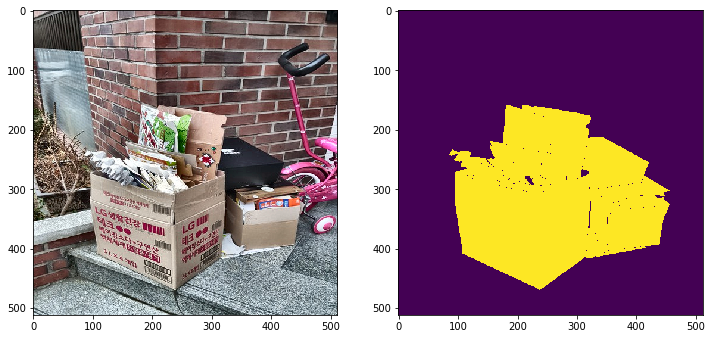

In [37]:
category_names = ["Backgroud","UNKNOWN","General trash","Paper","Paper pack","Metal","Glass","Plastic","Styrofoam","Plastic bag","Battery","Clothing"]
class_nums = len(category_names)

#CLAHE
def clahe_cvt(own_img) :
    lab = cv2.cvtColor(own_img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    cla_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return cla_img

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        #CLAHE Convert
        images = clahe_cvt(images)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())
    
# train.json / validation.json / test.json 디렉토리 설정
dataset_path = 'input/data'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch): return tuple(zip(*batch))

train_transform = A.Compose([
                           #A.CLAHE(),
                            #A.Resize(256, 256),
                            ToTensorV2(),
                            ])

val_transform = A.Compose([
                           #A.CLAHE(),
                          #A.Resize(256, 256),
                          ToTensorV2(),
                          ])

test_transform = A.Compose([
                           #A.CLAHE(),
                           #A.Resize(256, 256),
                           ToTensorV2(),
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

print(len(train_loader), len(val_loader), len(test_loader))

for x, y, _ in train_loader :
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    print(x[0].shape, y[0].shape)
    ax1.imshow(x[0].numpy().transpose(1, 2, 0))
    ax2.imshow(y[0])
    plt.show()
    
    break

## 3. 모델 구축

In [10]:
! pip install efficientunet-pytorch

  Created wheel for efficientunet-pytorch: filename=efficientunet_pytorch-0.0.6-py3-none-any.whl size=9457 sha256=dfdab0f8e2844da3e8d7ea78100d9e34fd56d0a166dabaa7104a41af44c11d44
  Stored in directory: /opt/ml/.cache/pip/wheels/84/c5/98/c9bb8ce1c9427466455cbbc3a8117485ca7eab38a03558457c
Successfully built efficientunet-pytorch


In [38]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model_b7 = get_efficientunet_b7(out_channels = class_nums, concat_input = True, pretrained = True).to(device)
optimizer_7 = Adam(model_b7.parameters(), lr = 0.001)
criterion_7 = nn.CrossEntropyLoss()
scheduler_7 = lr_scheduler.StepLR(optimizer_7, step_size = 7, gamma = 0.1)
'''
#제대로 된 전처리 찾으면 다 학습시켜서 앙상블할 예정.

model_b6 = get_efficientunet_b6(out_channels = class_nums, concat_input = True, pretrained = True).to(device)
optimizer_6 = Adam(model_b6.parameters(), lr = 0.001)
criterion_6 = nn.CrossEntropyLoss()
scheduler_6 = lr_scheduler.StepLR(optimizer_6, step_size = 7, gamma = 0.1)

model_b5 = get_efficientunet_b5(out_channels = class_nums, concat_input = True, pretrained = True).to(device)
optimizer_5 = Adam(model_b5.parameters(), lr = 0.001)
criterion_5 = nn.CrossEntropyLoss()
scheduler_5 = lr_scheduler.StepLR(optimizer_5, step_size = 7, gamma = 0.1)
'''

'\nmodel_b6 = get_efficientunet_b6(out_channels = class_nums, concat_input = True, pretrained = True).to(device)\noptimizer_6 = Adam(model_b6.parameters(), lr = 0.001)\ncriterion_6 = nn.CrossEntropyLoss()\nscheduler_6 = lr_scheduler.StepLR(optimizer_6, step_size = 7, gamma = 0.1)\n\nmodel_b5 = get_efficientunet_b5(out_channels = class_nums, concat_input = True, pretrained = True).to(device)\noptimizer_5 = Adam(model_b5.parameters(), lr = 0.001)\ncriterion_5 = nn.CrossEntropyLoss()\nscheduler_5 = lr_scheduler.StepLR(optimizer_5, step_size = 7, gamma = 0.1)\n'

  0%|          | 0/655 [00:00<?, ?it/s]

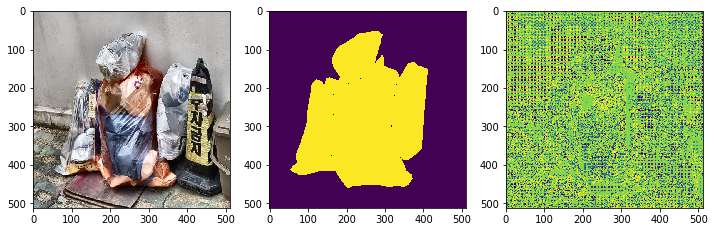

100%|██████████| 164/164 [00:31<00:00,  5.16it/s]


1 / 10 : train_loss = 0.8196, valid_loss = 0.1931
save the model : b7_original_clahe


  0%|          | 0/655 [00:00<?, ?it/s]

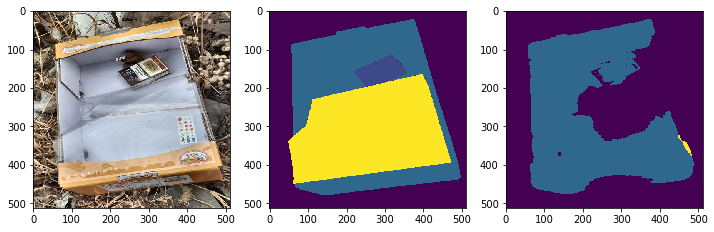

100%|██████████| 164/164 [00:31<00:00,  5.15it/s]


2 / 10 : train_loss = 0.6178, valid_loss = 0.1370
save the model : b7_original_clahe


  0%|          | 0/655 [00:00<?, ?it/s]

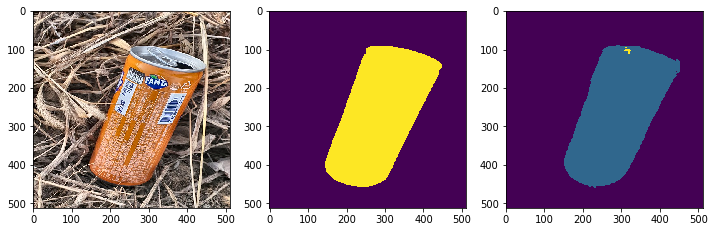

  0%|          | 0/655 [00:00<?, ?it/s]

3 / 10 : train_loss = 0.5700, valid_loss = 0.1379


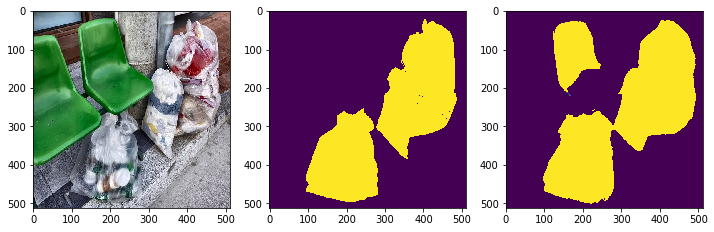

100%|██████████| 164/164 [00:32<00:00,  5.12it/s]


4 / 10 : train_loss = 0.5479, valid_loss = 0.1359
save the model : b7_original_clahe


  0%|          | 0/655 [00:00<?, ?it/s]

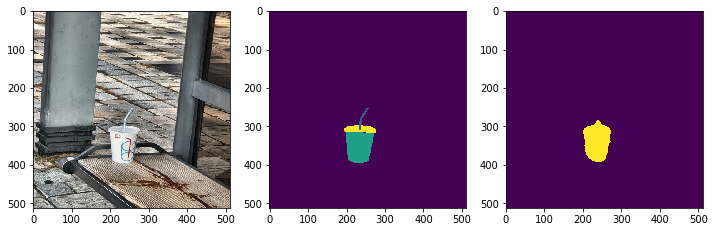

  0%|          | 0/655 [00:00<?, ?it/s]

5 / 10 : train_loss = 0.5213, valid_loss = 0.1450


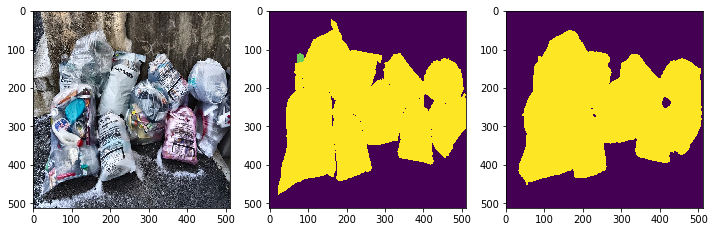

100%|██████████| 164/164 [00:31<00:00,  5.13it/s]


6 / 10 : train_loss = 0.4906, valid_loss = 0.1225
save the model : b7_original_clahe


  0%|          | 0/655 [00:00<?, ?it/s]

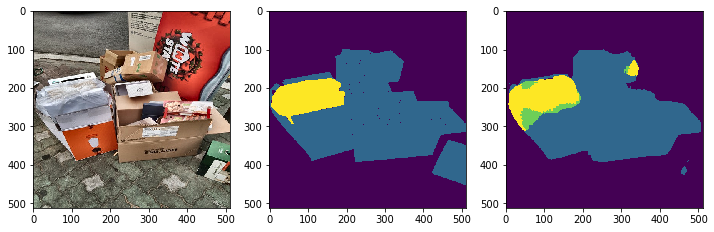

  0%|          | 0/655 [00:00<?, ?it/s]

7 / 10 : train_loss = 0.4740, valid_loss = 0.1240


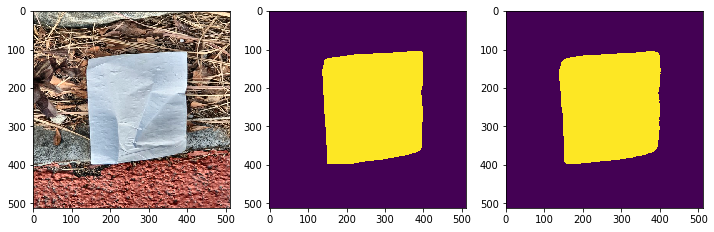

100%|██████████| 164/164 [00:32<00:00,  5.09it/s]


8 / 10 : train_loss = 0.4014, valid_loss = 0.1008
save the model : b7_original_clahe


  0%|          | 0/655 [00:00<?, ?it/s]

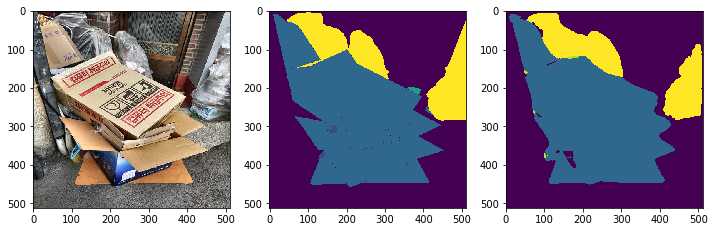

100%|██████████| 164/164 [00:31<00:00,  5.18it/s]


9 / 10 : train_loss = 0.3747, valid_loss = 0.0990
save the model : b7_original_clahe


  0%|          | 0/655 [00:00<?, ?it/s]

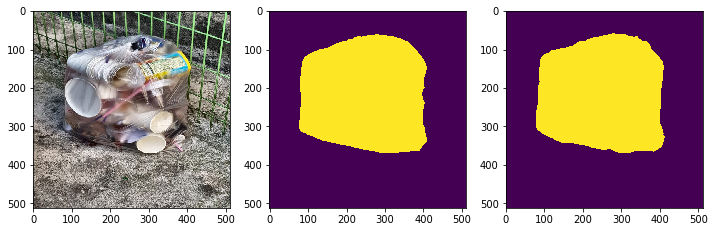

100%|██████████| 164/164 [00:31<00:00,  5.17it/s]

10 / 10 : train_loss = 0.3644, valid_loss = 0.0997


In [39]:
from tqdm import tqdm

n_epoch = 10 #parameter
best_val_loss = 999999
best_train_loss = 999999

for epoch in range(n_epoch) :
    #학습
    isFirst = True
    model_b7.train()
    train_loss = 0
    for x, y, _ in tqdm(train_loader) :
        x = torch.stack(x)       # (batch, channel, height, width)
        y = torch.stack(y).long()  # (batch, channel, height, width)
        x, y = x.to(device), y.to(device)
        
        predict = model_b7(x)
        
        if isFirst :
            with torch.no_grad() :
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
                isFirst = False
                x_np = x[0].to('cpu').numpy()
                x_np = np.transpose(x_np, (1, 2, 0))
                ax1.imshow(x_np)
                ax2.imshow(y[0].to('cpu'))
                
                oms = torch.argmax(predict[0].squeeze(), dim=0).detach().cpu().numpy()                
                ax3.imshow(oms)#, cmap='jet')
                plt.show()
            
        
        loss = criterion_7(predict, y)
        train_loss += loss.item()
        optimizer_7.zero_grad()
        loss.backward()
        optimizer_7.step()
        
    train_loss = train_loss / len(train_loader)
    #테스트
    model_b7.eval()
    valid_loss = 0
    with torch.no_grad() :
        for x, y, _ in tqdm(val_loader) :
            x = torch.stack(x)
            y = torch.stack(y).long()
            x, y = x.to(device), y.to(device)

            predict = model_b7(x)
            
            loss = criterion_7(predict, y)
            valid_loss += loss.item()
            
    valid_loss = valid_loss / len(train_loader)
    
    print('{0} / {1} : train_loss = {2:.4f}, valid_loss = {3:.4f}'.format(epoch+1, n_epoch, train_loss, valid_loss))
    if train_loss < best_train_loss and valid_loss < best_val_loss :
        best_train_loss = train_loss
        best_val_loss = valid_loss
        model_name = 'b7_original_clahe'
        print('save the model :', model_name)
        torch.save(model_b7.state_dict(), model_name + '.pt')
        
    if train_loss < 0.1 : 
        print('early stop')
        break
    scheduler_7.step()

In [40]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            if outs.shape[0] == 1 : oms = torch.argmax(outs.squeeze(), dim = 0).detach().cpu().numpy()
            else : oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            oms = oms.reshape(-1, 512, 512)
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array


# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
# test set에 대한 prediction
file_names, preds = test(model_b7, test_loader, device)
# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)
# submission.csv로 저장
submission.to_csv("./submission/b7_solo_basic_clahe.csv", index=False)

Start prediction.


210it [07:01,  2.01s/it]


End prediction.
